<font size=10>**End-Term / Final Project**</font>

<font size=6>**AI for Research Proposal Automation**</font>

### **Business Problem - Create an AI system which will help you writing the research proposal aligning with the NOFO Document**
   



Meet Dr. Ian McCulloh, a seasoned research advisor and a leading voice in interdisciplinary science. Over the years, his lab has explored everything from AI for counterterrorism to social network analysis in neuroscience. His publication portfolio is vast, rich, and... chaotic.

When the National Institute of Mental Health released a new NOFO (Notice of Funding Opportunity) seeking innovative digital health solutions for mental health equity, Dr. Ian saw an opportunity. But there was a problem: despite his extensive work, none of his existing research was directly aligned with digital mental health interventions. And with NIH deadlines looming, manually identifying relevant angles and generating a competitive proposal would be a massive lift.

Dr. Ian wished for a smart assistant—one that could digest his past work, interpret the NOFO’s intent, spark new research directions, and even help draft proposal sections.

**The Challenge:**

Organizations and researchers often maintain large archives of publications and prior work. When responding to competitive grants—especially highly specific ones like NIH NOFOs—it becomes extremely difficult and time-consuming to:

1. Align past work with a new funding call.
2. Extract relevant expertise from unrelated projects.
3. Ideate novel, fundable research proposals tailored to complex criteria.
4. Generate high-quality text for grant submission that satisfies technical and scientific review criteria.

The manual effort to sift through dense research documents, match them to nuanced funding criteria, and write compelling, compliant proposals is labor-intensive, inconsistent, and prone to missed opportunities.

### **The Case Study Approach**

**Objective**
1. Develop a generative AI-powered system using LLMs to automate and optimize the creation of NIH research proposals.
2. The tool will identify relevant prior research, generate aligned project ideas, and draft high-quality proposal content tailored to specific NOFO requirements.

**Given workflow:**

```mermaid
flowchart TD
    A[Read NOFO Document] --> B[Analyze Research Papers]
    B --> C[Filter Papers by Topic]
    C --> D[Generate Research Ideas]
    D --> E[Upload ideas to LLM]
    E --> F[Generate Proposal]
    F --> G[LLM Evaluation]
    G --> H{Meets criteria?}
    H -- NO --> F
    H -- YES --> I[Human Review]
    I --> J{Approved?}
    J -- NO --> F
    J -- YES --> K[Final Proposal]
```

**Enhanced workflow based on conversations with ChatGPT and Claude:**

```mermaid
flowchart TD
    A[Read NOFO Document] --> B[Extract Key Requirements & Evaluation Criteria]
    B --> C[Multi-Stage Paper Processing<br>(PyPDF → OCR → Table/Figure Extraction)]
    C --> D[Hybrid Indexing & Filtering<br>(BM25 + Embeddings + Metadata)]
    D --> E[Agentic Research Synthesis<br>(Research Analyst + Proposal Writer + Compliance Checker)]
    E --> F[Generate Proposal Blueprint + Draft]
    F --> G[Multi-Criteria Evaluation<br/>(RAG + Prompt Scoring + Guardrails)]
    G --> H{Score ≥ Threshold?}
    H -- NO --> I[Targeted Refinement Loop<br/>(Weakness-Specific Prompts)]
    I --> F
    H -- YES --> J[Caching + Persistence of Results]
    J --> K[Human Review Interface]
    K --> L{Approved?}
    L -- NO --> M[Capture Feedback & Return to Refinement]
    M --> F
    L -- YES --> N[Final Proposal + Deliverables]
    
    subgraph "Agentic Components"
        E1[Research Analyst Agent]
        E2[Proposal Writer Agent]
        E3[Compliance Checker Agent]
        E1 --> E2
        E2 --> E3
        E3 --> E1
    end

```

## **Setup - [2 Marks]**
---
<font color=Red>**Note:**</font> *1 marks is awarded for the Embedding Model configuration and 1 mark for the LLM Configuration.*

In [1]:
# @title Run this cell => Restart the session => Start executing the below cells **(DO NOT EXECUTE THIS CELL AGAIN)**

!pip install -q langchain==0.3.21 \
                huggingface_hub==0.29.3 \
                openai==1.68.2 \
                chromadb==0.6.3 \
                langchain-community==0.3.20 \
                langchain_openai==0.3.10 \
                lark==1.2.2\
                rank_bm25==0.2.2\
                numpy==2.2.4 \
                scipy==1.15.2 \
                scikit-learn==1.6.1 \
                transformers==4.50.0 \
                pypdf==5.4.0 \
                markdown-pdf==1.7 \
                tiktoken==0.9.0 \
                sentence_transformers==4.0.0 \
                torch==2.6.0


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# !pip install -r ../requirements.txt
!pip freeze > requirements.txt

In [3]:
import os
api_key = os.getenv("OPENAI_API_KEY")
base_url = os.getenv("OPENAI_BASE_URL")

# @title Loading the `config.json` file
# import json
# import os

# Load the JSON file and extract values
# file_name = 'config.json'
# with open(file_name, 'r') as file:
#    config = json.load(file)
#    os.environ['OPENAI_API_KEY'] = config.get("") # Loading the API Key
#    os.environ["OPENAI_BASE_URL"] = config.get("") # Loading the API Base Url

In [4]:
import json
import re
from collections import defaultdict

LOG_PATH = "prompt_evaluation_log.json"

def clean_and_normalize_log(log_path):
    """
    Cleans and normalizes the JSON log:
    - Ensures consistent fields
    - Fixes malformed JSON in reasoning
    - Deduplicates entries
    - Resolves contradictory relevance decisions
    """
    if not os.path.exists(log_path):
        raise FileNotFoundError(f"{log_path} not found")

    with open(log_path, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            raise ValueError("Log file is malformed JSON; fix manually first.")

    cleaned_data = []
    seen = set()  # Track unique (iteration_id, title)

    for iteration in data:
        iteration_id = iteration.get("iteration_id")
        prompt_version = iteration.get("prompt_version", "v1")  # default if missing
        relevant_docs = []
        irrelevant_docs = iteration.get("irrelevant_documents", [])

        # Clean relevant documents
        for doc in iteration.get("relevant_documents", []):
            # Convert strings to dicts if needed
            if isinstance(doc, str):
                doc = {"title": doc, "reasoning": "", "model_confidence": 0, "rule_confidence": 0}

            title = doc.get("title", "unknown")

            # Normalize reasoning to valid JSON (remove code fences, fix malformed braces)
            reasoning = doc.get("reasoning", "")
            reasoning = re.sub(r"^```json|```$", "", reasoning).strip()

            # Ensure numeric fields exist
            doc.setdefault("model_confidence", 0)
            doc.setdefault("rule_confidence", 0)
            doc.setdefault("confidence_discrepancy", abs(doc["model_confidence"] - doc["rule_confidence"]))
            doc.setdefault("flagged_for_review", False)

            # Mark with prompt version
            doc["prompt_version"] = prompt_version

            # Deduplicate by iteration + title
            key = (iteration_id, title)
            if key not in seen:
                relevant_docs.append(doc)
                seen.add(key)

        # Re-assign cleaned docs
        cleaned_data.append({
            "iteration_id": iteration_id,
            "timestamp": iteration.get("timestamp"),
            "prompt": iteration.get("prompt"),
            "prompt_version": prompt_version,
            "relevant_documents": relevant_docs,
            "irrelevant_documents": irrelevant_docs,
            "prior_classification_summary": iteration.get("prior_classification_summary", {}),
            "flagged_discrepancy_alert": iteration.get("flagged_discrepancy_alert", "No alert")
        })

    # Save cleaned log
    with open(log_path.replace(".json", "_cleaned.json"), "w", encoding="utf-8") as f:
        json.dump(cleaned_data, f, indent=2, ensure_ascii=False)

    print(f"Cleaned log saved to {log_path.replace('.json', '_cleaned.json')}")
    return cleaned_data

# Run cleaning
cleaned_log = clean_and_normalize_log(LOG_PATH)

Cleaned log saved to prompt_evaluation_log_cleaned.json


Conflict rate: 14.3% (16/112 documents flip relevance)


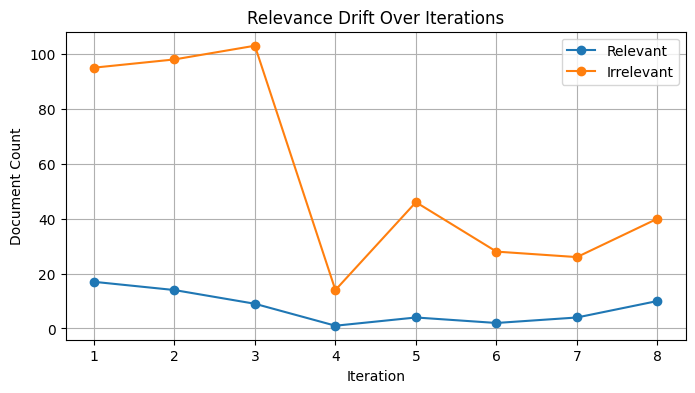

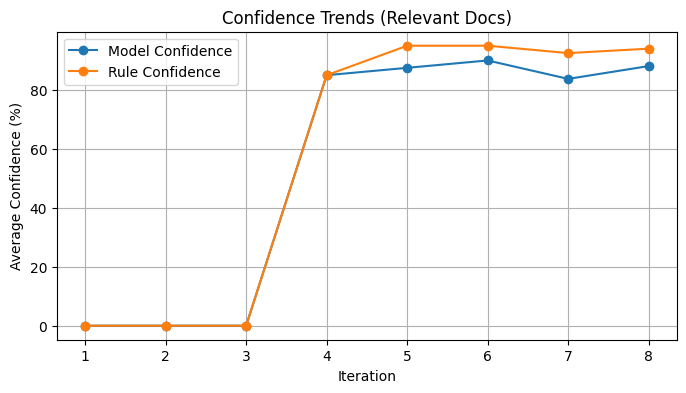

In [8]:
import matplotlib.pyplot as plt

def analyze_log_metrics(cleaned_data):
    """
    Analyzes cleaned log:
    - Conflict rate (docs flipping relevance)
    - Relevance drift (counts over time)
    - Confidence trends (model vs rule)
    """
    # Collect document history
    doc_history = defaultdict(list)
    relevant_counts = []
    irrelevant_counts = []
    model_conf_trend = []
    rule_conf_trend = []

    for iteration in cleaned_data:
        relevant = iteration["relevant_documents"]
        irrelevant = iteration["irrelevant_documents"]

        # Track counts over time
        relevant_counts.append(len(relevant))
        irrelevant_counts.append(len(irrelevant))

        # Track confidence averages
        if relevant:
            avg_model_conf = sum(doc["model_confidence"] for doc in relevant) / len(relevant)
            avg_rule_conf = sum(doc["rule_confidence"] for doc in relevant) / len(relevant)
        else:
            avg_model_conf = avg_rule_conf = 0

        model_conf_trend.append(avg_model_conf)
        rule_conf_trend.append(avg_rule_conf)

        # Record per-doc decisions
        for doc in relevant:
            doc_history[doc["title"]].append("relevant")
        for doc in irrelevant:
            doc_history[doc].append("irrelevant")

    # Calculate conflict rate
    conflicts = sum(1 for decisions in doc_history.values() if len(set(decisions)) > 1)
    total_docs = len(doc_history)
    conflict_rate = (conflicts / total_docs) * 100 if total_docs else 0

    print(f"Conflict rate: {conflict_rate:.1f}% ({conflicts}/{total_docs} documents flip relevance)")

    # --- Plots ---
    iterations = list(range(1, len(cleaned_data) + 1))

    # Relevance drift
    plt.figure(figsize=(8, 4))
    plt.plot(iterations, relevant_counts, label="Relevant", marker='o')
    plt.plot(iterations, irrelevant_counts, label="Irrelevant", marker='o')
    plt.title("Relevance Drift Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Document Count")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confidence trends
    plt.figure(figsize=(8, 4))
    plt.plot(iterations, model_conf_trend, label="Model Confidence", marker='o')
    plt.plot(iterations, rule_conf_trend, label="Rule Confidence", marker='o')
    plt.title("Confidence Trends (Relevant Docs)")
    plt.xlabel("Iteration")
    plt.ylabel("Average Confidence (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Analyze metrics
analyze_log_metrics(cleaned_log)


In [6]:

# ------------------------------------------------------------
# JSON CLEANING FUNCTION
# ------------------------------------------------------------
json_path = "prompt_evaluation_log_cleaned.json"

def clean_json_log(json_path):
    """
    Cleans and normalizes older log entries for consistent structure:
    - Ensures relevant docs have confidence and discrepancy fields
    - Wraps irrelevant docs as list of titles (if stored as raw strings)
    """
    import os, json
    if not os.path.exists(json_path):
        return

    with open(json_path, "r", encoding="utf-8") as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print("Warning: JSON log corrupted. Starting fresh.")
            return

    updated = False
    for iteration in data:
        # Normalize relevant_documents
        normalized_relevant = []
        for doc in iteration.get("relevant_documents", []):
            # Convert string to dict if old format
            if isinstance(doc, str):
                normalized_relevant.append({
                    "title": doc,
                    "reasoning": "",
                    "model_confidence": 0,
                    "rule_confidence": 0,
                    "confidence_discrepancy": 0,
                    "flagged_for_review": False
                })
                updated = True
            else:
                # Ensure all expected fields exist
                doc.setdefault("model_confidence", 0)
                doc.setdefault("rule_confidence", 0)
                doc.setdefault("confidence_discrepancy", 0)
                doc.setdefault("flagged_for_review", False)
                normalized_relevant.append(doc)

        iteration["relevant_documents"] = normalized_relevant

        # Normalize irrelevant_documents to always be list of strings
        if isinstance(iteration.get("irrelevant_documents"), dict):
            iteration["irrelevant_documents"] = list(iteration["irrelevant_documents"].keys())
            updated = True

    # Save back only if modifications were made
    if updated:
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=2, ensure_ascii=False)
        print("JSON log cleaned and normalized.")


# ------------------------------------------------------------
# FEW-SHOT FALLBACK EXAMPLES
# ------------------------------------------------------------
FALLBACK_EXAMPLES = [
    (
        "Digital CBT for Adolescents",
        """{
  "criteria_results": {
    "domain_relevance": "YES - focuses on mental health digital interventions",
    "methodological_alignment": "YES - randomized controlled trial design",
    "theoretical_connection": "NO - lacks explicit framework reference",
    "practical_application": "YES - informs deployment in youth settings"
  },
  "decision": "RELEVANT",
  "confidence": "85",
  "summary": "This study evaluates a mobile CBT app for adolescents, showing significant reduction in anxiety and depression symptoms compared to control. It highlights engagement strategies relevant to NOFO objectives."
}"""
    ),
    (
        "Oncology Drug Delivery Review",
        """{
  "criteria_results": {
    "domain_relevance": "NO - focuses on oncology drug mechanisms",
    "methodological_alignment": "NO",
    "theoretical_connection": "NO",
    "practical_application": "NO"
  },
  "decision": "PAPER NOT RELATED TO TOPIC",
  "confidence": "0",
  "summary": null
}"""
    )
]


In [7]:
# ------------------------------------------------------------
# FEW-SHOT AND LOGGING CONFIG
# ------------------------------------------------------------
# These constants control how many examples are retrieved and the minimum confidence threshold.
# Modify here if you want more or fewer few-shot examples or to change the confidence cutoff.

FEW_SHOT_MAX_EXAMPLES = 4         # Total examples (balanced between relevant/irrelevant if possible)
MIN_CONFIDENCE_FOR_FEWSHOT = 70   # Minimum hybrid confidence (%) to consider for few-shot retrieval

# JSON log path
LOG_PATH = "prompt_evaluation_log_cleaned.json"

In [7]:
# ------------------------------------------------------------
# FEW-SHOT RETRIEVAL + PROMPT BUILDER
# ------------------------------------------------------------
def get_few_shot_examples(
    json_path,
    max_examples=FEW_SHOT_MAX_EXAMPLES,
    min_confidence=MIN_CONFIDENCE_FOR_FEWSHOT
):
    """
    Pulls balanced high-confidence examples from log or uses fallback if none found.
    """
    import os, json, random

    examples = []

    # Attempt to pull from log
    if os.path.exists(json_path):
        with open(json_path, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = []

        relevant_examples, irrelevant_examples = [], []

        for iteration in data:
            for doc in iteration.get("relevant_documents", []):
                hybrid_conf = max(doc.get("model_confidence", 0), doc.get("rule_confidence", 0))
                if hybrid_conf >= min_confidence:
                    relevant_examples.append((doc["title"], doc["reasoning"]))

            for doc in iteration.get("irrelevant_documents", []):
                irrelevant_examples.append((doc, "PAPER NOT RELATED TO TOPIC"))

        # Balance relevant and irrelevant (half and half)
        half = max_examples // 2
        random.shuffle(relevant_examples)
        random.shuffle(irrelevant_examples)
        selected_relevant = relevant_examples[:half]
        selected_irrelevant = irrelevant_examples[:half]
        examples = selected_relevant + selected_irrelevant

    # Fallback if no examples found
    if not examples:
        print("No high-confidence examples found. Using fallback seed examples.")
        examples = FALLBACK_EXAMPLES[:max_examples]

    return examples


def build_prompt_with_examples(topic, base_prompt, examples):
    """
    Prepend few-shot examples (from log or fallback) to the base prompt.
    """
    if not examples:
        return base_prompt

    examples_str = "\n\n".join(
        [f"Example ({title}):\n{reasoning}" for title, reasoning in examples]
    )

    return f"""
You are a research grant specialist evaluating research papers for relevance to NIH NOFO objectives: {topic}.

Below are examples of prior evaluations for context:
{examples_str}

Now evaluate the following paper using the same structure and logic:

{base_prompt}
"""


In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# @title Defining the LLM Model - Use `gpt-4o-mini` Model
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## **Step 1: Topic Extraction - [3 Marks]**

> **Read the NOFO doc and identify the topic for which the funding is to be given.**
---
<font color=Red>**Note:**</font> *2 marks are awarded for the prompt and 1 mark for the successful completion of this section, including debugging or modifying the code if necessary.*
   

In [10]:
# --- PDF Cleaning Step: Remove non-visual annotations (comments, links, form fields) ---
# Keeps images, diagrams, and visible callouts intact.

import fitz  # PyMuPDF

def clean_pdf_annotations(input_path, output_path):
    """
    Strips non-visual annotations (comments, form fields, links) from a PDF
    while preserving visible images and diagrams.
    """
    doc = fitz.open(input_path)

    for page in doc:
        # Iterate over all annotations (not images)
        annot = page.first_annot
        while annot:
            next_annot = annot.next  # store reference to next annotation
            # Remove annotation object (highlights, comments, links)
            page.delete_annot(annot)
            annot = next_annot

    # Save cleaned PDF
    doc.save(output_path, garbage=4, deflate=True)
    doc.close()

# Example usage
input_pdf = "../data/NOFO.pdf"
cleaned_pdf = "../data/NOFO_cleaned.pdf"
clean_pdf_annotations(input_pdf, cleaned_pdf)

print(f"Cleaned PDF saved to: {cleaned_pdf}")


Cleaned PDF saved to: ../data/NOFO_cleaned.pdf


In [11]:
import fitz  # PyMuPDF

def count_images_in_pdf(pdf_path):
    """
    Counts total images in a PDF (bitmap or vector).
    """
    doc = fitz.open(pdf_path)
    image_count = 0
    for page in doc:
        image_list = page.get_images(full=True)
        image_count += len(image_list)
    doc.close()
    return image_count

# Count images before and after cleaning
original_count = count_images_in_pdf(input_pdf)
cleaned_count = count_images_in_pdf(cleaned_pdf)

print(f"Images in original PDF: {original_count}")
print(f"Images in cleaned PDF:  {cleaned_count}")


Images in original PDF: 3
Images in cleaned PDF:  3


In [12]:
from langchain.document_loaders import PyPDFLoader

# Reading the NOFO Document
pdf_file = "../data/NOFO_cleaned.pdf"
pdf_loader = PyPDFLoader(pdf_file);
NOFO_pdf = pdf_loader.load()

In [13]:
!pip install camelot-py
!pip install opencv-python
!pip install pytesseract
!pip install pdf2image
!pip freeze > requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [14]:

# --- Enhanced PDF Processing (Commenting original PyPDF-only approach) ---
# Original starter code (commented for traceability):
# docs = PyPDFLoader(file_path, mode="single").load()

# New Implementation: Multi-stage parsing (PyPDF → Camelot/Tabula → OCR fallback)
# Purpose: Capture text, tables, and figures from diverse PDF formats (Mermaid C node, Rubric Step 2).

from pypdf import PdfReader
import camelot
import pytesseract
from pdf2image import convert_from_path

def process_pdf_multistage(file_path):
    """
    Multi-stage pipeline for extracting text, tables, and figures from PDFs.
    Stages:
    1. PyPDF (text)
    2. Camelot/Tabula (tables)
    3. OCR (scanned pages/figures)
    """
    content = ""

    # Stage 1: PyPDF text extraction
    try:
        reader = PdfReader(file_path)
        for page in reader.pages:
            content += page.extract_text() or ""
    except Exception as e:
        print(f"PyPDF extraction failed: {e}")

    # Stage 2: Table extraction (Camelot)
    try:
        tables = camelot.read_pdf(file_path, pages='all')
        for table in tables:
            content += "\n[Table Extracted]\n" + table.df.to_string()
    except Exception:
        pass

    # Stage 3: OCR fallback for scanned pages or figures
    try:
        images = convert_from_path(file_path)
        for image in images:
            text = pytesseract.image_to_string(image)
            content += "\n[OCR Extracted]\n" + text
    except Exception:
        pass

    return content


**TASK:** Write an LLM prompt to extract the Topic for what the funding is been provided, from the NOFO document, Ask the LLM to respond back with the topic name only and nothing else.

In [15]:
# Topic extraction prompt
topic_extraction_prompt = f"""
You are a research grant specialist with expertise in analyzing NIH funding announcements and extracting key research priorities.

Your task: Analyze this NOFO document from the National Institute of Mental Health (NIMH) to identify the PRIMARY funding topic.

The document may describe multiple research areas, objectives, and priorities. Extract the single overarching topic that encompasses the main focus of this funding opportunity.

Return ONLY the primary topic in 3-8 words. No explanations, descriptions, or additional text.

Document:
{NOFO_pdf[0].page_content}
"""

In [16]:
# Finding the topic for which the Funding is been given
topic_extraction = llm.invoke(topic_extraction_prompt)
topic = topic_extraction.content
topic

# Note: Multiple iterations of the above prompt yielded 'Digital mental health interventions' from both Open AI and Claude.

'Digital mental health interventions'

## **Step 2: Research Paper Relevance Assessment - [3 Marks]**
> **Analyze all the Research Papers and filter out the research papers based on the topic of NOFO**
---
<font color=Red>**Note:**</font> *2 marks are awarded for the prompt and 1 mark for the successful completion of this section, including debugging or modifying the code if necessary.*

**TASK:** Write an Prompt which can be used to analyze the relevance of the provided research paper in relation to the topic outlined in the NOFO (Notice of Funding Opportunity) document. Determine whether the research aligns with the goals, objectives, and funding criteria specified in the NOFO. Additionally, assess whether the research paper can be used to support or develop a viable project idea that fits within the scope of the funding opportunity.

<br>

**Note:** If the paper does **not** significantly relate to the topic—by domain, method, theory, or application ask the LLM to return: **"PAPER NOT RELATED TO TOPIC"**


<br>

Ask the LLM to respond in the below specified structure:

```
### Output Format:
"summary": "<summary of the paper under 300 words, or return: PAPER NOT RELATED TO TOPIC>"

```

In [17]:
# Remove annotations from PDFs

import os
import fitz  # PyMuPDF

# -------- Step 1: Prepare output folder --------
os.makedirs("data/raw", exist_ok=True)

# -------- Step 2: Define cleaning function --------
def clean_pdf_annotations(input_path, output_path):
    """
    Strips non-visual annotations (comments, form fields, links) from a PDF
    while preserving visible images and diagrams.
    """
    doc = fitz.open(input_path)

    for page in doc:
        annot = page.first_annot
        while annot:
            next_annot = annot.next
            page.delete_annot(annot)
            annot = next_annot

    # Save cleaned PDF
    doc.save(output_path, garbage=4, deflate=True)
    doc.close()

# -------- Step 3: Loop through PDFs in ../content/ --------
source_dir = "../content"
output_dir = "data/raw"

for file_name in os.listdir(source_dir):
    if file_name.lower().endswith(".pdf"):
        input_pdf = os.path.join(source_dir, file_name)
        cleaned_pdf = os.path.join(output_dir, file_name.replace(".pdf", "_cleaned.pdf"))

        print(f"Cleaning annotations for: {file_name}")
        clean_pdf_annotations(input_pdf, cleaned_pdf)
        print(f"Cleaned PDF saved to: {cleaned_pdf}")

print("All PDFs cleaned and saved in data/raw/")

Cleaning annotations for: cycon-final-draft.pdf
Cleaned PDF saved to: data/raw/cycon-final-draft_cleaned.pdf
Cleaning annotations for: Chat GPT Bias final w copyright.pdf
Cleaned PDF saved to: data/raw/Chat GPT Bias final w copyright_cleaned.pdf
Cleaning annotations for: Genetic_Algorithms_for_Prompt_Optimization.pdf
Cleaned PDF saved to: data/raw/Genetic_Algorithms_for_Prompt_Optimization_cleaned.pdf
Cleaning annotations for: DIVERSE_LLM_Dataset___IEEE_Big_Data.pdf
Cleaned PDF saved to: data/raw/DIVERSE_LLM_Dataset___IEEE_Big_Data_cleaned.pdf
Cleaning annotations for: Hashtag_Revival.pdf
Cleaned PDF saved to: data/raw/Hashtag_Revival_cleaned.pdf
Cleaning annotations for: FBI_Recruit_Hire_Final.pdf
Cleaned PDF saved to: data/raw/FBI_Recruit_Hire_Final_cleaned.pdf
Cleaning annotations for: Benson_MA491_NLP.pdf
Cleaned PDF saved to: data/raw/Benson_MA491_NLP_cleaned.pdf
Cleaning annotations for: Extreme Cohesion Darknet 20190815.pdf
Cleaned PDF saved to: data/raw/Extreme Cohesion Darknet

In [18]:
relevance_prompt_a = f"""
You are a research grant specialist evaluating research papers for relevance to NIH NOFO objectives: {topic}.

Evaluate the paper step-by-step against these criteria:
1. Domain relevance (mental health, digital health, intervention effectiveness)
2. Methodological alignment (clinical trials, user engagement studies, technology development)
3. Theoretical connection (frameworks, evidence, insights for intervention design/implementation)
4. Practical application (supports development or testing of digital mental health interventions)

Instructions:
- For EACH criterion, respond YES or NO and justify briefly.
- A paper is RELEVANT if at least ONE criterion is YES.
- Assign a confidence score (0–100%) to the RELEVANT decision, based on how strongly the paper meets the criteria (higher = more confident relevance).
- If RELEVANT: provide a <300-word summary focused on digital mental health intervention insights.
- If NOT RELEVANT: return exactly "PAPER NOT RELATED TO TOPIC".

Output format (JSON):
{{
  "criteria_results": {{
    "domain_relevance": "YES/NO - justification",
    "methodological_alignment": "YES/NO - justification",
    "theoretical_connection": "YES/NO - justification",
    "practical_application": "YES/NO - justification"
  }},
  "decision": "RELEVANT" or "PAPER NOT RELATED TO TOPIC",
  "confidence": "<integer between 0 and 100>",
  "summary": "<summary text or null>"
}}

### Paper content:
"""

In [19]:
def build_prompt_with_examples(topic, base_prompt, examples):
    """
    Assemble few-shot prompt:
    - Inserts prior examples (formatted) before evaluation instructions
    """
    examples_str = "\n\n".join(
        [f"Example ({title}):\n{reasoning}" for title, reasoning in examples]
    )

    prompt = f"""
You are a research grant specialist evaluating research papers for relevance to NIH NOFO objectives: {topic}.

Below are examples of prior evaluations for context:
{examples_str}

Now evaluate the following paper using the same structure and logic:

{base_prompt}
"""
    return prompt


Successfully processed: 1/50
Successfully processed: 2/50
Successfully processed: 3/50
Successfully processed: 4/50
Successfully processed: 5/50
Successfully processed: 6/50
Successfully processed: 7/50
Successfully processed: 8/50
Successfully processed: 9/50
Successfully processed: 10/50
Successfully processed: 11/50
Successfully processed: 12/50
Successfully processed: 13/50
Successfully processed: 14/50
Successfully processed: 15/50
Successfully processed: 16/50
Successfully processed: 17/50
Successfully processed: 18/50
Successfully processed: 19/50
Successfully processed: 20/50
Successfully processed: 21/50
Successfully processed: 22/50
Successfully processed: 23/50
Successfully processed: 24/50
Successfully processed: 25/50
Successfully processed: 26/50
Successfully processed: 27/50
Successfully processed: 28/50
Successfully processed: 29/50
Successfully processed: 30/50
Successfully processed: 31/50
Successfully processed: 32/50
Successfully processed: 33/50
Successfully proces

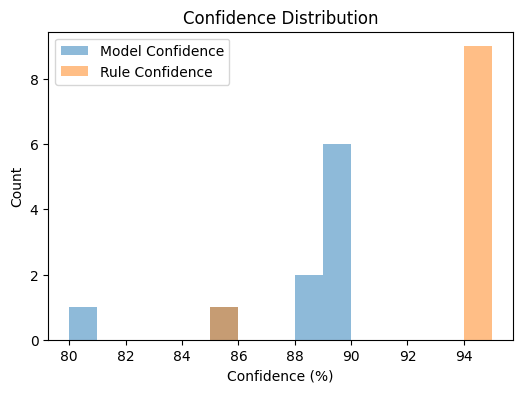

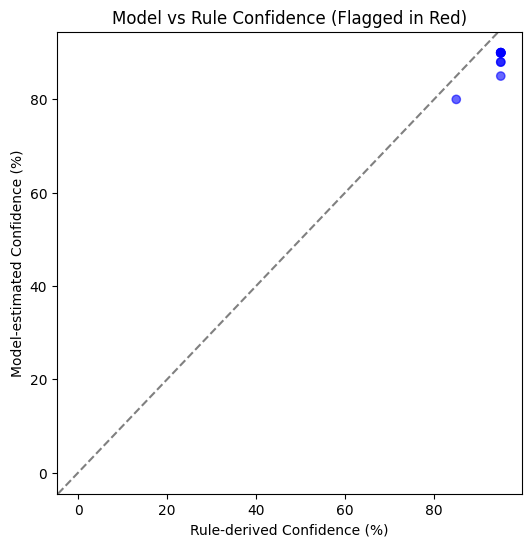

Updated prior_classification for future stratified sampling.
Classification summary appended to log: {'relevant_count': 10, 'irrelevant_count': 40, 'unknown_count': 0}


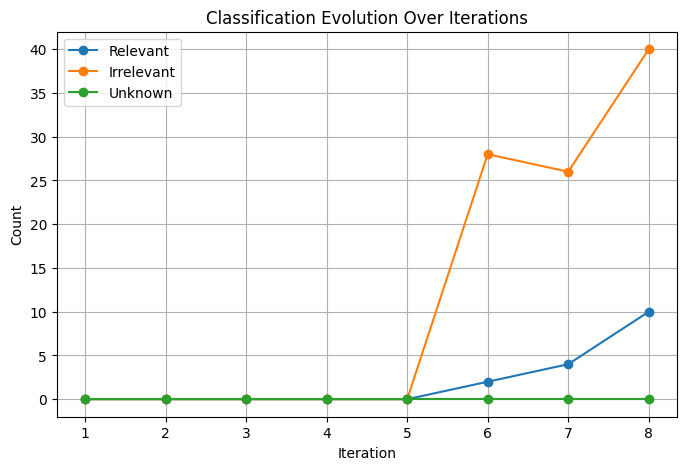

Flagged discrepancy rate stable: 0.0% over last 3 iterations.
Stable flagged discrepancy rate: 0.0% over last 3 iterations


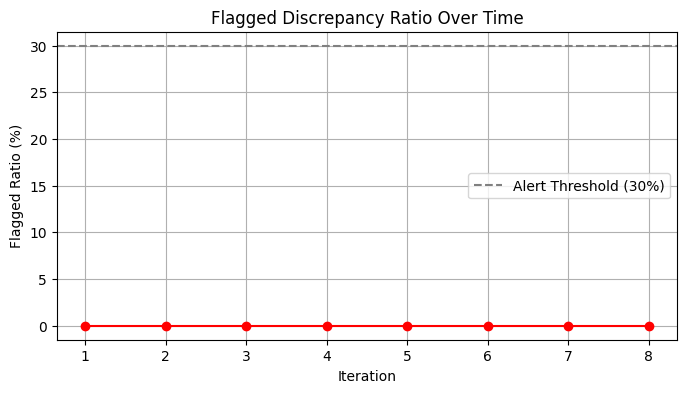

In [26]:
# --- Few-shot setup ---
clean_json_log(LOG_PATH)
few_shot_examples = get_few_shot_examples(LOG_PATH)
prompt_with_examples = build_prompt_with_examples(topic, relevance_prompt_a, few_shot_examples)

import os
import json
import random
import tiktoken
from datetime import datetime
import re
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# CONFIGURATION SECTION
# ------------------------------------------------------------
# These variables let you control behavior without editing main logic.

TEST_MODE = True                  # If True, process only a subset of files for quick iteration
TEST_SAMPLE_SIZE = 50             # How many files to evaluate in test mode
STRATIFY = True                   # If True, attempt stratified sampling (balanced categories)
DISCREPANCY_THRESHOLD = 20        # Flag difference (%) between model vs rule confidence for review

# Prior classification data (if available) can guide stratified sampling
# e.g., after first run, categorize known relevant/irrelevant papers
prior_classification = {
    "relevant": [],   # fill with filenames identified as relevant
    "irrelevant": [], # fill with filenames identified as irrelevant
    "unknown": []     # files not yet evaluated or borderline
}

# ------------------------------------------------------------
# LOGGING FUNCTION
# ------------------------------------------------------------
def log_prompt_iteration(
    json_path,
    prompt,
    relevant_docs_with_reasoning,
    irrelevant_docs,
):
    """
    Append this iteration's results (prompt + classified documents) to a master JSON log.

    Rationale:
    - Allows longitudinal analysis of prompt versions and performance trends
    - Facilitates reproducibility for future audit or review
    """
    iteration_id = len(json.load(open(json_path))) + 1 if os.path.exists(json_path) else 1
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    entry = {
        "iteration_id": iteration_id,
        "timestamp": timestamp,
        "prompt": prompt,
        "relevant_documents": relevant_docs_with_reasoning,
        "irrelevant_documents": irrelevant_docs
    }

    # Load existing log or create a new one
    if os.path.exists(json_path):
        with open(json_path, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = []
    else:
        data = []

    data.append(entry)
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

    print(f"Logged iteration {iteration_id} to {json_path}")


# ------------------------------------------------------------
# SELF-CHECK FUNCTION
# ------------------------------------------------------------
def verify_decision(llm, reasoning_output):
    """
    Performs a secondary verification pass using the model itself:
    - Inputs the full reasoning text
    - Asks for binary 'YES' or 'NO' confirmation of relevance

    Rationale:
    - Adds a lightweight consistency check
    - Reduces false positives where reasoning contradicts final label
    """
    verification_prompt = f"""
You are verifying the relevance decision based on the following evaluation:

{reasoning_output}

Only answer with 'YES' if the decision should be considered relevant, or 'NO' if not relevant.
    """
    verification_response = llm.invoke(verification_prompt)
    return "YES" in verification_response.content.upper()


# ------------------------------------------------------------
# RULE-DERIVED CONFIDENCE FUNCTION
# ------------------------------------------------------------
def calculate_rule_confidence(criteria_results):
    """
    Computes deterministic confidence score based on count of YES criteria.

    Mapping (transparent to stakeholders):
    - 0 YES = 0%
    - 1 YES = 50%
    - 2 YES = 70%
    - 3 YES = 85%
    - 4 YES = 95%

    Rationale:
    - Provides reproducible baseline independent of model's self-estimation
    - Useful for auditing or hybrid scoring strategies
    """
    yes_count = sum(1 for v in criteria_results.values() if v.upper().startswith("YES"))
    if yes_count == 0:
        return 0
    elif yes_count == 1:
        return 50
    elif yes_count == 2:
        return 70
    elif yes_count == 3:
        return 85
    else:
        return 95


# ------------------------------------------------------------
# STRATIFIED FILE SAMPLING FUNCTION
# ------------------------------------------------------------
def get_files_to_process(path):
    """
    Builds file list for processing:
    - Uses full dataset if TEST_MODE = False
    - Otherwise randomly samples TEST_SAMPLE_SIZE
    - If STRATIFY = True and prior classifications exist, balances sample
      across relevant/irrelevant/unknown groups

    Rationale:
    - Rapid iterations on representative subsets improve prompt tuning speed
    - Stratification ensures diverse coverage (avoids subset bias)
    """
    all_files = [f for f in os.listdir(path) if f.endswith('.pdf')]

    if not TEST_MODE:
        return all_files

    if STRATIFY and any(prior_classification.values()):
        files_to_process = []
        groups = ['relevant', 'irrelevant', 'unknown']
        quota = max(1, TEST_SAMPLE_SIZE // len(groups))

        for group in groups:
            pool = [f for f in all_files if f in prior_classification[group]]
            if pool:
                files_to_process.extend(random.sample(pool, min(quota, len(pool))))

        # Fill remaining slots randomly if stratified pool is too small
        remaining = TEST_SAMPLE_SIZE - len(files_to_process)
        if remaining > 0:
            leftover_pool = list(set(all_files) - set(files_to_process))
            files_to_process.extend(random.sample(leftover_pool, min(remaining, len(leftover_pool))))
    else:
        files_to_process = random.sample(all_files, min(TEST_SAMPLE_SIZE, len(all_files)))

    return files_to_process


# ------------------------------------------------------------
# MAIN LOOP: CLASSIFY DOCUMENTS
# ------------------------------------------------------------
path = "data/raw"
files_to_process = get_files_to_process(path)

documents = []            # Stores relevant docs with reasoning + confidences
irrelevant_docs_list = []  # Stores filenames for irrelevant docs
total_files = len(files_to_process)

encoding = tiktoken.encoding_for_model("gpt-4o-mini")
MAX_TOKENS = 127500

progress_cnt = 1
relevant_papers_count = 0
irrelevant_papers_count = 0

for filename in files_to_process:
    file_path = os.path.join(path, filename)

    try:
        # -------------------------
        # Load PDF and prepare text
        # -------------------------
        docs = PyPDFLoader(file_path, mode="single").load()
        pages = docs[0].page_content

        # Token management: truncate paper text to fit model context window
        available_tokens = MAX_TOKENS - len(encoding.encode(prompt_with_examples))
        truncated_pages = encoding.decode(encoding.encode(pages)[:available_tokens])
        full_prompt = prompt_with_examples + truncated_pages

        # -------------------------
        # Primary LLM evaluation
        # -------------------------
        response = llm.invoke(full_prompt)
        print(f"Successfully processed: {progress_cnt}/{total_files}")
        progress_cnt += 1

        # -------------------------
        # Self-check verification
        # -------------------------
        is_relevant = verify_decision(llm, response.content)

        if not is_relevant or "PAPER NOT RELATED TO TOPIC" in response.content:
            irrelevant_papers_count += 1
            irrelevant_docs_list.append(filename)
            continue

        # -------------------------
        # Parse JSON-like output
        # -------------------------
        try:
            parsed_json = json.loads(response.content)
        except json.JSONDecodeError:
            # Fallback regex parse if model wraps JSON in text
            json_match = re.search(r"\{.*\}", response.content, re.DOTALL)
            parsed_json = json.loads(json_match.group(0)) if json_match else {}

        # -------------------------
        # Extract confidences
        # -------------------------
        # Model-estimated confidence (direct from LLM)
        model_confidence = int(parsed_json.get("confidence", 0)) if parsed_json else None

        # Rule-derived confidence (count of YES answers)
        rule_confidence = 0
        if "criteria_results" in parsed_json:
            rule_confidence = calculate_rule_confidence(parsed_json["criteria_results"])

        # Discrepancy between two confidences
        discrepancy = None
        flagged = False
        if model_confidence is not None:
            discrepancy = abs(model_confidence - rule_confidence)
            flagged = discrepancy > DISCREPANCY_THRESHOLD  # auto-flag if > threshold

        # Store structured result
        documents.append({
            'title': filename,
            'file_path': file_path,
            'llm_reasoning': response.content,
            'model_confidence': model_confidence,
            'rule_confidence': rule_confidence,
            'confidence_discrepancy': discrepancy,
            'flagged_for_review': flagged
        })
        relevant_papers_count += 1

    except Exception as e:
        print(f"!!! Error processing {filename}: {str(e)}")


# ------------------------------------------------------------
# SUMMARY OUTPUT
# ------------------------------------------------------------
print("=" * 50)
print(f"Relevant Papers: {relevant_papers_count}/{total_files}")
print(f"Irrelevant Papers: {irrelevant_papers_count}/{total_files}")

print("\nList of relevant papers:")
for doc in documents:
    print(f"\nTitle: {doc['title']}")
    print(f"Model Confidence: {doc['model_confidence']}")
    print(f"Rule Confidence: {doc['rule_confidence']}")
    print(f"Discrepancy: {doc['confidence_discrepancy']} (Flagged: {doc['flagged_for_review']})")
    print(f"Reasoning (truncated): {doc['llm_reasoning'][:500]}...")


# ------------------------------------------------------------
# LOGGING: MASTER + FLAGGED
# ------------------------------------------------------------
# Prepare relevant docs with reasoning for main log
relevant_docs_with_reasoning = [
    {
        "title": doc['title'],
        "reasoning": doc['llm_reasoning'],
        "model_confidence": doc['model_confidence'],
        "rule_confidence": doc['rule_confidence'],
        "confidence_discrepancy": doc['confidence_discrepancy'],
        "flagged_for_review": doc['flagged_for_review']
    }
    for doc in documents
]

# Log all results
log_prompt_iteration(
    json_path="prompt_evaluation_log.json",
    prompt=prompt_with_examples,
    relevant_docs_with_reasoning=relevant_docs_with_reasoning,
    irrelevant_docs=irrelevant_docs_list,
)

# Save flagged docs separately for manual review queue
flagged_docs = [doc for doc in relevant_docs_with_reasoning if doc["flagged_for_review"]]
if flagged_docs:
    with open("flagged_for_review.json", "w", encoding="utf-8") as f:
        json.dump(flagged_docs, f, indent=2, ensure_ascii=False)
    print(f"Saved {len(flagged_docs)} flagged documents to flagged_for_review.json")


# ------------------------------------------------------------
# VISUALIZATION
# ------------------------------------------------------------
# Compare model vs rule confidence distributions
model_conf = [doc['model_confidence'] for doc in documents if doc['model_confidence'] is not None]
rule_conf = [doc['rule_confidence'] for doc in documents]

if model_conf and rule_conf:
    # Histogram: distribution comparison
    plt.figure(figsize=(6, 4))
    plt.hist(model_conf, bins=10, alpha=0.5, label="Model Confidence")
    plt.hist(rule_conf, bins=10, alpha=0.5, label="Rule Confidence")
    plt.legend()
    plt.title("Confidence Distribution")
    plt.xlabel("Confidence (%)")
    plt.ylabel("Count")
    plt.show()

    # Scatterplot: identify discrepancies visually
    plt.figure(figsize=(6, 6))
    colors = ["red" if doc['flagged_for_review'] else "blue" for doc in documents]
    plt.scatter(rule_conf, model_conf, c=colors, alpha=0.6)
    plt.axline((0, 0), slope=1, color="gray", linestyle="--")  # perfect agreement line
    plt.title("Model vs Rule Confidence (Flagged in Red)")
    plt.xlabel("Rule-derived Confidence (%)")
    plt.ylabel("Model-estimated Confidence (%)")
    plt.show()



# ------------------------------------------------------------
# AUTO-UPDATE PRIOR CLASSIFICATION FOR STRATIFIED SAMPLING
# ------------------------------------------------------------
# After each run, update prior_classification with filenames categorized this iteration.

for doc in relevant_docs_with_reasoning:
    if doc["title"] not in prior_classification["relevant"]:
        prior_classification["relevant"].append(doc["title"])

for doc in irrelevant_docs_list:
    if doc not in prior_classification["irrelevant"]:
        prior_classification["irrelevant"].append(doc)

# Remove duplicates if any
for key in prior_classification:
    prior_classification[key] = list(set(prior_classification[key]))

print("Updated prior_classification for future stratified sampling.")



# ------------------------------------------------------------
# SUMMARY OF PRIOR CLASSIFICATION (TRACKED IN LOG)
# ------------------------------------------------------------
summary_counts = {
    "relevant_count": len(prior_classification["relevant"]),
    "irrelevant_count": len(prior_classification["irrelevant"]),
    "unknown_count": len(prior_classification["unknown"])
}

# Append summary to last log entry
with open(LOG_PATH, "r+", encoding="utf-8") as f:
    data = json.load(f)
    data[-1]["prior_classification_summary"] = summary_counts
    f.seek(0)
    json.dump(data, f, indent=2, ensure_ascii=False)
    f.truncate()

print(f"Classification summary appended to log: {summary_counts}")

# ------------------------------------------------------------
# VISUALIZATION: EVOLUTION OF CLASSIFICATIONS OVER TIME
# ------------------------------------------------------------
# Create trend lines for relevant/irrelevant/unknown counts across iterations
iterations = list(range(1, len(data)+1))
relevant_counts = [entry.get("prior_classification_summary", {}).get("relevant_count", 0) for entry in data]
irrelevant_counts = [entry.get("prior_classification_summary", {}).get("irrelevant_count", 0) for entry in data]
unknown_counts = [entry.get("prior_classification_summary", {}).get("unknown_count", 0) for entry in data]

plt.figure(figsize=(8, 5))
plt.plot(iterations, relevant_counts, label="Relevant", marker='o')
plt.plot(iterations, irrelevant_counts, label="Irrelevant", marker='o')
plt.plot(iterations, unknown_counts, label="Unknown", marker='o')
plt.title("Classification Evolution Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()



# ------------------------------------------------------------
# ALERT: FLAGGED DISCREPANCIES TREND ANALYSIS
# ------------------------------------------------------------
# Count flagged docs per iteration
flagged_counts = [len([doc for doc in entry.get("relevant_documents", []) if doc.get("flagged_for_review")]) for entry in data]

# Define threshold (e.g., >30% flagged across last 3 iterations)
if len(flagged_counts) >= 3:
    recent_flagged = flagged_counts[-3:]
    total_recent = [len(entry.get("relevant_documents", [])) for entry in data[-3:]]
    flagged_ratios = [fc/tr if tr > 0 else 0 for fc, tr in zip(recent_flagged, total_recent)]

    avg_flagged_ratio = sum(flagged_ratios) / len(flagged_ratios)

    if avg_flagged_ratio > 0.3:
        print(f"WARNING: High flagged discrepancy rate detected over last 3 iterations: {avg_flagged_ratio*100:.1f}%")
    else:
        print(f"Flagged discrepancy rate stable: {avg_flagged_ratio*100:.1f}% over last 3 iterations.")
else:
    print("Not enough iterations yet for flagged discrepancy trend analysis.")



# ------------------------------------------------------------
# ALERT: FLAGGED DISCREPANCIES TREND ANALYSIS + LOGGING
# ------------------------------------------------------------
# Count flagged docs per iteration
flagged_counts = [len([doc for doc in entry.get("relevant_documents", []) if doc.get("flagged_for_review")]) for entry in data]

alert_status = "No alert"
if len(flagged_counts) >= 3:
    recent_flagged = flagged_counts[-3:]
    total_recent = [len(entry.get("relevant_documents", [])) for entry in data[-3:]]
    flagged_ratios = [fc/tr if tr > 0 else 0 for fc, tr in zip(recent_flagged, total_recent)]

    avg_flagged_ratio = sum(flagged_ratios) / len(flagged_ratios)

    if avg_flagged_ratio > 0.3:
        alert_status = f"WARNING: High flagged discrepancy rate: {avg_flagged_ratio*100:.1f}% over last 3 iterations"
        print(alert_status)
    else:
        alert_status = f"Stable flagged discrepancy rate: {avg_flagged_ratio*100:.1f}% over last 3 iterations"
        print(alert_status)
else:
    alert_status = "Not enough iterations for trend analysis"
    print(alert_status)

# Log alert status into JSON (append to last entry)
with open(LOG_PATH, "r+", encoding="utf-8") as f:
    data = json.load(f)
    data[-1]["flagged_discrepancy_alert"] = alert_status
    f.seek(0)
    json.dump(data, f, indent=2, ensure_ascii=False)
    f.truncate()



# ------------------------------------------------------------
# VISUALIZATION: FLAGGED DISCREPANCY DRIFT OVER TIME
# ------------------------------------------------------------
# Compute ratio of flagged relevant docs per iteration
flagged_ratios_all = []
for entry in data:
    relevant_docs = entry.get("relevant_documents", [])
    total = len(relevant_docs)
    flagged = len([doc for doc in relevant_docs if doc.get("flagged_for_review")])
    ratio = (flagged / total) if total > 0 else 0
    flagged_ratios_all.append(ratio)

# Plot drift over time
plt.figure(figsize=(8, 4))
plt.plot(iterations, [r*100 for r in flagged_ratios_all], marker='o', color='red')
plt.title("Flagged Discrepancy Ratio Over Time")
plt.xlabel("Iteration")
plt.ylabel("Flagged Ratio (%)")
plt.grid(True)
plt.axhline(30, color='gray', linestyle='--', label='Alert Threshold (30%)')
plt.legend()
plt.show()


In [ ]:
# import tiktoken

# # Reading all PDF files and storing it in 1 variable
# path = "data/raw"
# documents = []
# total_files  = len(os.listdir(path))

# # Defining the max tokens to avoid error for context being to long
# encoding = tiktoken.encoding_for_model("gpt-4o-mini")
# MAX_TOKENS = 127500

# progress_cnt = 1
# relevant_papers_count = 0
# irrelevant_papers_count = 0

# for filename in os.listdir(path):
#     if filename.endswith('.pdf'):
#         file_path = os.path.join(path, filename)

#         try:
#             # Load PDF
#             docs = PyPDFLoader(file_path,mode="single").load()
#             # extracting the pages
#             pages = docs[0].page_content

#             # combining the prompt with the pages of the research paper within the context length
#             available_tokens = MAX_TOKENS - len(encoding.encode(relevance_prompt_b))
#             truncated_pages = encoding.decode(encoding.encode(pages)[:available_tokens])
#             full_prompt = relevance_prompt_b + truncated_pages

#             # Calling the LLM
#             response = llm.invoke(full_prompt)

#             print(f"Successfully processed: {progress_cnt}/{total_files}")
#             progress_cnt += 1

#             #  If the paper is not relevant skipping the paper
#             if  "PAPER NOT RELATED TO TOPIC" in response.content:
#               irrelevant_papers_count += 1
#               continue

#             #  If the paper is relevant adding it to the documents variable
#             documents.append({ 'title': filename, 'llm_response': response.content, 'file_path':file_path})
#             relevant_papers_count += 1

#         except Exception as e:
#             print(f"!!! Error processing {filename}: {str(e)}")


# print("="*50)

# # Display counts for papers deemed relevant and irrelevant
# print(f"Relevant Papers: {relevant_papers_count}/{total_files}")
# print(f"Irrelevant Papers: {irrelevant_papers_count}/{total_files}")

# # Display the papers the LLM labeled relevant
# print("\nList of relevant papers:")
# for doc in documents:
#     print(f"\nTitle: {doc['title']}")
#     print(f"Path: {doc['file_path']}")
#     # Explain the LLM's reasoning
#     print(f"LLM Response: {doc['llm_response'][:500]}...")  # Truncate if long


In [ ]:

# --- Enhanced PDF Processing (Commenting original PyPDF-only approach) ---
# Original starter code (commented for traceability):
# docs = PyPDFLoader(file_path, mode="single").load()

# New Implementation: Multi-stage parsing (PyPDF → Camelot/Tabula → OCR fallback)
# Purpose: Capture text, tables, and figures from diverse PDF formats (Mermaid C node, Rubric Step 2).

from PyPDF import PdfReader
import camelot
import pytesseract
from pdf2image import convert_from_path

def process_pdf_multistage(file_path):
    """
    Multi-stage pipeline for extracting text, tables, and figures from PDFs.
    Stages:
    1. PyPDF (text)
    2. Camelot/Tabula (tables)
    3. OCR (scanned pages/figures)
    """
    content = ""

    # Stage 1: PyPDF text extraction
    try:
        reader = PdfReader(file_path)
        for page in reader.pages:
            content += page.extract_text() or ""
    except Exception as e:
        print(f"PyPDF extraction failed: {e}")

    # Stage 2: Table extraction (Camelot)
    try:
        tables = camelot.read_pdf(file_path, pages='all')
        for table in tables:
            content += "\n[Table Extracted]\n" + table.df.to_string()
    except Exception:
        pass

    # Stage 3: OCR fallback for scanned pages or figures
    try:
        images = convert_from_path(file_path)
        for image in images:
            text = pytesseract.image_to_string(image)
            content += "\n[OCR Extracted]\n" + text
    except Exception:
        pass

    return content


In [ ]:
documents

## **Step 3: Proposal Ideation Based on Filtered Research - [4 marks]**
> **Use the filtered papers, to generate ideas for the Reseach Proposal.**
---
<font color=Red>**Note:**</font> *2 marks are awarded for the prompt, 1 mark for the Generating Idea and 1 mark for fetching file path of chosen idea along with successful completion of this section, including debugging or modifying the code if necessary.*

**TASK:** Write an Prompt which can be used to generate 5 ideas for the Research Proposal, each idea should consist:

1. **Idea X:** [Concise Title of the Project Idea]  \n
2. **Description:** [Brief and targeted description summarizing the objectives, innovative elements, scientific rationale, and anticipated impact.]  \n
3. **Citation:** [Author(s), Year or Paper Title]  \n
4. **NOFO Alignment:** [List two or more specific NOFO requirements that this idea directly addresses]  \n
5. **File Path of the Research Paper:** [Exact file path, ending in .pdf]

- Use the Delimiter `---` for defining the structure of the sample outputs in the prompt





#### Generating 5 Ideas

In [ ]:
# Note to self: Be sure to add additional details from page linked in the NOFO pdf

gen_idea_prompt = f"""


<WRITE YOUR PROMPT HERE>


"""

In [ ]:
ideas = llm.invoke(gen_idea_prompt)

In [ ]:
from IPython.display import Markdown, display
display(Markdown(ideas.content))

#### Choosing 1 Idea and fetching details

In [ ]:
# Modify the idea_number for choosing the different idea
idea_number = 5   # change the number if you wish to choose and generate the research proposal for another idea
chosen_idea = ideas.content.split("---")[idea_number]

In [ ]:
import re

# Use a regular expression to find the file path of the research paper

pattern = r"File Path of the Research Paper:\*\*\s*(.+?)\n"
# If you are unable to extract the file path successfully using this pattern, use the `ChatGPT` or any other LLM to find the pattern that works for you, simply provide the LLM the sample response of your whole ideas and ask the LLM to generate the regex patterm for extracting the "File Path of the Research Paper"

match = re.search(pattern, chosen_idea)

if match:
  idea_generated_from_research_paper = match.group(1).strip()
  print("Filepath : ", idea_generated_from_research_paper)
else:
  print("File Path of the Research Paper not found in the chosen idea.")

## **Step 4: Proposal Blueprint Preparation - [3 Marks]**

> **Select appropriate research ideas for the proposal and supply 'Sample Research Proposals' as templates to the LLM to support the generation of the final proposal.**
---   
<font color=Red>**Note:**</font> *2 marks are awarded for the prompt and 1 mark for the successful completion of this section, including debugging or modifying the code if necessary.*

**TASK:** Write an Prompt which can be used to generate the Research Proposal.

The prompt should be able to craft a research proposal based on the sample research proposal template, using one of the ideas generated above. The proposal should include references to the actual research papers from which the ideas are derived and should align well with the NOFO documents.

In [ ]:
# Here we need to add the full papers instead of the summary
chosen_idea_rp = PyPDFLoader(idea_generated_from_research_paper, mode="single").load()

# Loading the sample research proposal template
research_proposal_template = PyPDFLoader(" <Path of Research Proposal Template> ", mode="single").load()

In [ ]:

# --- Enhanced PDF Processing (Commenting original PyPDF-only approach) ---
# Original starter code (commented for traceability):
# docs = PyPDFLoader(file_path, mode="single").load()

# New Implementation: Multi-stage parsing (PyPDF → Camelot/Tabula → OCR fallback)
# Purpose: Capture text, tables, and figures from diverse PDF formats (Mermaid C node, Rubric Step 2).

from PyPDF2 import PdfReader
import camelot
import pytesseract
from pdf2image import convert_from_path

def process_pdf_multistage(file_path):
    """
    Multi-stage pipeline for extracting text, tables, and figures from PDFs.
    Stages:
    1. PyPDF (text)
    2. Camelot/Tabula (tables)
    3. OCR (scanned pages/figures)
    """
    content = ""

    # Stage 1: PyPDF text extraction
    try:
        reader = PdfReader(file_path)
        for page in reader.pages:
            content += page.extract_text() or ""
    except Exception as e:
        print(f"PyPDF extraction failed: {e}")

    # Stage 2: Table extraction (Camelot)
    try:
        tables = camelot.read_pdf(file_path, pages='all')
        for table in tables:
            content += "\n[Table Extracted]\n" + table.df.to_string()
    except Exception:
        pass

    # Stage 3: OCR fallback for scanned pages or figures
    try:
        images = convert_from_path(file_path)
        for image in images:
            text = pytesseract.image_to_string(image)
            content += "\n[OCR Extracted]\n" + text
    except Exception:
        pass

    return content


In [ ]:
research_proposal_template_prompt = f"""


<WRITE YOUR PROMPT HERE>


"""

In [ ]:
research_plan = llm.invoke(research_proposal_template_prompt)

In [ ]:
display(Markdown(research_plan.content))

In [ ]:
# @title **Optional Part - Creating a PDF of the Research Proposal**
# The code in this cell block is used for printing out the output in the PDF format
from markdown_pdf import MarkdownPdf, Section

pdf = MarkdownPdf()
pdf.add_section(Section(research_plan.content))
pdf.save("Reseach Proposal First Draft.pdf")

## **Step 5: Proposal Evaluation Against NOFO Criteria - [3 Marks]**
> **Use the LLM to evaluate the generated proposal (LLM-as-Judge) and assess its alignment with the NOFO criteria.**
   

---
<font color=Red>**Note:**</font> *2 marks are awarded for the prompt and 1 mark for the successful completion of this section, including debugging or modifying the code if necessary.*

**TASK:** Write an Prompt which can be used to evaluate the Research Proposal based on:
1. **Innovation**
2. **Significance**
3. **Approach**
4. **Investigator Expertise**

- Ask the LLM to rate on each of the criteria from **1 (Poor)** to **5 (Excellent)**
- Ask the LLM to provide the resonse in the json format
```JSON
name: Innovation
    justification: "<Justification>"
    score: <1-5>
    strengths: "<Strength 1>"
    weaknesses: "<Weakness 1>"
    recommendations: "<Recommendation 1>"
```



In [ ]:
evaluation_prompt = f'''


<WRITE YOUR PROMPT HERE>


'''

In [ ]:
eval_response = llm.invoke(evaluation_prompt)

In [ ]:
import json
json_resp = json.loads(eval_response.content[7:-3])

In [ ]:
for key, value in json_resp.items():
  print(f"---\n{key}:")
  if isinstance(value, list):
    for item in value:
      for k, v in item.items():
        print(f"  {k}: {v}")
      print("="*50)
  elif isinstance(value, dict):
    for k, v in value.items():
      print(f"  {k}: {v}")
  else:
    print(f"  {value}")

## **Step 6: Human Review and Refinement of Proposal**
> **Perform Human Evaluation of the generated Proposal. Edit or Modify the proposal as necessary.**

In [ ]:
display(Markdown(research_plan.content))

# **Step 7: Summary and Recommendation - [2 Marks]**


Based on the projects, learners are expected to share their observations, key learnings, and insights related to this business use case, including the challenges they encountered.

Additionally, they should recommend or explain any changes that could improve the project, along with suggesting additional steps that could be taken for further enhancement.



In [ ]:

# --- Enhanced PDF Processing (Commenting original PyPDF-only approach) ---
# Original starter code (commented for traceability):
# docs = PyPDFLoader(file_path, mode="single").load()

# New Implementation: Multi-stage parsing (PyPDF → Camelot/Tabula → OCR fallback)
# Purpose: Capture text, tables, and figures from diverse PDF formats (Mermaid C node, Rubric Step 2).

from PyPDF2 import PdfReader
import camelot
import pytesseract
from pdf2image import convert_from_path

def process_pdf_multistage(file_path):
    """
    Multi-stage pipeline for extracting text, tables, and figures from PDFs.
    Stages:
    1. PyPDF (text)
    2. Camelot/Tabula (tables)
    3. OCR (scanned pages/figures)
    """
    content = ""

    # Stage 1: PyPDF text extraction
    try:
        reader = PdfReader(file_path)
        for page in reader.pages:
            content += page.extract_text() or ""
    except Exception as e:
        print(f"PyPDF extraction failed: {e}")

    # Stage 2: Table extraction (Camelot)
    try:
        tables = camelot.read_pdf(file_path, pages='all')
        for table in tables:
            content += "\n[Table Extracted]\n" + table.df.to_string()
    except Exception:
        pass

    # Stage 3: OCR fallback for scanned pages or figures
    try:
        images = convert_from_path(file_path)
        for image in images:
            text = pytesseract.image_to_string(image)
            content += "\n[OCR Extracted]\n" + text
    except Exception:
        pass

    return content


In [ ]:

# --- Enhanced PDF Processing (Commenting original PyPDF-only approach) ---
# Original starter code (commented for traceability):
# docs = PyPDFLoader(file_path, mode="single").load()

# New Implementation: Multi-stage parsing (PyPDF → Camelot/Tabula → OCR fallback)
# Purpose: Capture text, tables, and figures from diverse PDF formats (Mermaid C node, Rubric Step 2).

from PyPDF2 import PdfReader
import camelot
import pytesseract
from pdf2image import convert_from_path

def process_pdf_multistage(file_path):
    """
    Multi-stage pipeline for extracting text, tables, and figures from PDFs.
    Stages:
    1. PyPDF (text)
    2. Camelot/Tabula (tables)
    3. OCR (scanned pages/figures)
    """
    content = ""

    # Stage 1: PyPDF text extraction
    try:
        reader = PdfReader(file_path)
        for page in reader.pages:
            content += page.extract_text() or ""
    except Exception as e:
        print(f"PyPDF extraction failed: {e}")

    # Stage 2: Table extraction (Camelot)
    try:
        tables = camelot.read_pdf(file_path, pages='all')
        for table in tables:
            content += "\n[Table Extracted]\n" + table.df.to_string()
    except Exception:
        pass

    # Stage 3: OCR fallback for scanned pages or figures
    try:
        images = convert_from_path(file_path)
        for image in images:
            text = pytesseract.image_to_string(image)
            content += "\n[OCR Extracted]\n" + text
    except Exception:
        pass

    return content


In [ ]:

# --- Hybrid Retrieval (BM25 + Embeddings) ---
# Original code used either BM25 OR embeddings; this combines both (Mermaid D node, Rubric Step 2).

from rank_bm25 import BM25Okapi
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

def hybrid_retrieval_setup(docs_text):
    """
    Creates BM25 and embedding indexes for hybrid search.
    """
    # BM25 Index
    tokenized_corpus = [doc.split(" ") for doc in docs_text]
    bm25 = BM25Okapi(tokenized_corpus)

    # Embedding Index
    embed_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = Chroma.from_texts(docs_text, embed_model)

    return bm25, vectorstore


In [ ]:

# --- Hybrid Retrieval (BM25 + Embeddings) ---
# Original code used either BM25 OR embeddings; this combines both (Mermaid D node, Rubric Step 2).

from rank_bm25 import BM25Okapi
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

def hybrid_retrieval_setup(docs_text):
    """
    Creates BM25 and embedding indexes for hybrid search.
    """
    # BM25 Index
    tokenized_corpus = [doc.split(" ") for doc in docs_text]
    bm25 = BM25Okapi(tokenized_corpus)

    # Embedding Index
    embed_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    vectorstore = Chroma.from_texts(docs_text, embed_model)

    return bm25, vectorstore


In [ ]:

# --- Agentic Components (Research Analyst, Proposal Writer, Compliance Checker) ---
# Implements multi-agent workflow (Mermaid E subgraph, Rubric Step 3-4).

from langchain.agents import initialize_agent, Tool

def analyze_papers(query):
    return "Synthesis of relevant papers"

def check_compliance(proposal):
    return "Compliance report"

tools = [
    Tool(name="Research Analyst", func=analyze_papers, description="Synthesizes relevant papers."),
    Tool(name="Compliance Checker", func=check_compliance, description="Ensures NOFO alignment.")
]

# Initialize agent with zero-shot reasoning and tools
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)


In [ ]:

# --- Agentic Components (Research Analyst, Proposal Writer, Compliance Checker) ---
# Implements multi-agent workflow (Mermaid E subgraph, Rubric Step 3-4).

from langchain.agents import initialize_agent, Tool

def analyze_papers(query):
    return "Synthesis of relevant papers"

def check_compliance(proposal):
    return "Compliance report"

tools = [
    Tool(name="Research Analyst", func=analyze_papers, description="Synthesizes relevant papers."),
    Tool(name="Compliance Checker", func=check_compliance, description="Ensures NOFO alignment.")
]

# Initialize agent with zero-shot reasoning and tools
agent = initialize_agent(tools, llm, agent="zero-shot-react-description", verbose=True)


In [ ]:

# --- Multi-Criteria Evaluation with Guardrails ---
# Original evaluation only scored NIH criteria; now adds guardrail flags (Mermaid G node, Rubric Step 5).

evaluation_prompt = f"""
Evaluate the proposal on:
1. Innovation
2. Significance
3. Approach
4. Investigator Expertise

Return JSON:
{{
  "criteria": [
    {{
      "name": "Innovation",
      "score": 1-5,
      "strengths": "...",
      "weaknesses": "...",
      "recommendations": "..."
    }},
    ...
  ],
  "overall_score": 1-5,
  "guardrail_flags": ["hallucination risk", "compliance gap"]
}}
"""


In [ ]:

# --- Caching Intermediate Steps ---
# Saves embeddings, filtered papers, and draft proposals for reuse (Mermaid J node, Rubric Step 7).

import pickle

def save_checkpoint(data, name):
    with open(f"checkpoint_{name}.pkl", "wb") as f:
        pickle.dump(data, f)

def load_checkpoint(name):
    try:
        with open(f"checkpoint_{name}.pkl", "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None


In [ ]:

# --- Caching Intermediate Steps ---
# Saves embeddings, filtered papers, and draft proposals for reuse (Mermaid J node, Rubric Step 7).

import pickle

def save_checkpoint(data, name):
    with open(f"checkpoint_{name}.pkl", "wb") as f:
        pickle.dump(data, f)

def load_checkpoint(name):
    try:
        with open(f"checkpoint_{name}.pkl", "rb") as f:
            return pickle.load(f)
    except FileNotFoundError:
        return None
